<center>
<h4>Universidad Nacional de Córdoba - Facultad de Matemática, Astronomía, Física y Computación</h4>
<h3>Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones</h3>
</center>

### Aprendizaje NO supervisado - 2019 
#### Práctico: Reglas de Asociación

Integrantes: Johanna Frau, Lucía Benítez y Nair Trógolo

#### Tarea: 

* Obtener reglas de asociación entre películas en el dataset movilents
* Aplicar diferentes métricas de ordenamiento


En estre práctico se va a trabajar sobre el dataset MovieLens 20M Dataset (https://grouplens.org/datasets/movielens/20m/) que describe ratings y free-text tagging activities de MovieLens,que es un servicio de recomendación de películas. 


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from efficient_apriori import apriori
from itertools import combinations, groupby

In [5]:
np.random.seed(1234) #para hacer reproducible el experimento

No se incluye información demográfica. Cada usuario está representado solo por un id.
Los datos se distribuyen en seis archivos: 

* **tags.csv**, contiene las etiquetas aplicadas de las películas, por los usuarios: 

    * userId
    * movieId
    * tag
    * timestamp

* **ratings.csv**, contiene los ratings de las películas por los usuarios: 

    * userId
    * movieId
    * rating
    * timestamp
    
* **movies.csv**, contiene la información de la película:
    * movieId
    * title
    * genres

* **links.csv** contiene identificadores que pueden ser usados para acceder a otras fuentes: 
    * movieId 
    * imdbId
    * tmbdId

* **genome-scores.csv** contiene etiquetas de relevancia para la película:
    * movieId
    * tagId
    * relevance

* **genome-tags.csv** contiene la descripción de las etiquetas:
    * tagId 
    * tag

Vamos a analizar especialmente los archivos: *ratings.csv* y *movies.csv*, ya que queremos encontrar reglas de asociación entre películas y los usuarios (como sistema de recomendación)

In [6]:
movies = pd.read_csv('movies_1.csv')
movies.head(10)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


In [7]:
movies.sample(5)

,movieId,title,genres
5443,26003,Night and Fog (Nuit et brouillard) (1955),Crime|Documentary|War
3134,4218,River's Edge (1986),Crime|Drama
2888,3863,"Cell, The (2000)",Drama|Horror|Thriller
8443,111817,Jimi: All Is by My Side (2013),Drama
1165,1545,Ponette (1996),Drama


In [8]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
movieId    9742 non-null int64
title      9742 non-null object
genres     9742 non-null object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


El dataset de movies tiene 3 columnas de features:

- Identificador de Películas (movieId)
- Título de la película junto con el año de lanzamiento (title)
- Géneros a los cuales pertenece la película (genres). 

In [9]:
new_movies = movies
new_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


## Preparación de los datos

### Creación de la columna year

Ahora crearemos una nueva columna que contenga sólo el año de las películas.

In [10]:
new_movies['year'] = new_movies['title'].str.rsplit(')',1).str[0].str.rsplit('(',1).str[1]
new_movies['year'].head()

0    1995
1    1995
2    1995
3    1995
4    1995
Name: year, dtype: object

Veamos si dicha columna quedó bien chequeando los valores únicos.

In [11]:
new_movies['year'].unique()

array(['1995', '1994', '1996', '1976', '1992', '1967', '1993', '1964',
       '1977', '1965', '1982', '1990', '1991', '1989', '1937', '1940',
       '1969', '1981', '1973', '1970', '1955', '1959', '1968', '1988',
       '1997', '1972', '1943', '1952', '1951', '1957', '1961', '1958',
       '1954', '1934', '1944', '1960', '1963', '1942', '1941', '1953',
       '1939', '1950', '1946', '1945', '1938', '1947', '1935', '1936',
       '1956', '1949', '1932', '1975', '1974', '1971', '1979', '1987',
       '1986', '1980', '1978', '1985', '1966', '1962', '1983', '1984',
       '1948', '1933', '1931', '1922', '1998', '1929', '1930', '1927',
       '1928', '1999', '2000', '1926', '1919', '1921', '1925', '1923',
       '2001', '2002', '2003', '1920', '1915', '1924', '2004', '1916',
       '1917', '2005', '2006', '1902', nan, '1903', '2007', '2008',
       '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016',
       '2017', '2018', '1908', '2006–2007'], dtype=object)

Observamos que dado que hay un valor anómalo en la columna year como 2006–2007 y también valores nulos.

Procedemos a declarar estos índices como 'no year'.

In [12]:
new_movies[new_movies['year']=='2006–2007'] 

,movieId,title,genres,year
9518,171749,Death Note: Desu nôto (2006–2007),(no genres listed),2006–2007


In [13]:
new_movies.at[9518, 'year'] = 'no year' 

Chequeamos nuevamente los valores únicos en la columna year.

In [14]:
new_movies['year'].unique()

array(['1995', '1994', '1996', '1976', '1992', '1967', '1993', '1964',
       '1977', '1965', '1982', '1990', '1991', '1989', '1937', '1940',
       '1969', '1981', '1973', '1970', '1955', '1959', '1968', '1988',
       '1997', '1972', '1943', '1952', '1951', '1957', '1961', '1958',
       '1954', '1934', '1944', '1960', '1963', '1942', '1941', '1953',
       '1939', '1950', '1946', '1945', '1938', '1947', '1935', '1936',
       '1956', '1949', '1932', '1975', '1974', '1971', '1979', '1987',
       '1986', '1980', '1978', '1985', '1966', '1962', '1983', '1984',
       '1948', '1933', '1931', '1922', '1998', '1929', '1930', '1927',
       '1928', '1999', '2000', '1926', '1919', '1921', '1925', '1923',
       '2001', '2002', '2003', '1920', '1915', '1924', '2004', '1916',
       '1917', '2005', '2006', '1902', nan, '1903', '2007', '2008',
       '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016',
       '2017', '2018', '1908', 'no year'], dtype=object)

En las filas con valores nulos colocamos la categoría "no year".

In [15]:
year_null = new_movies[new_movies['year'].isnull()]

In [16]:
index_year_null = np.array(year_null.index)
index_year_null

array([6059, 9031, 9091, 9138, 9179, 9259, 9367, 9448, 9514, 9515, 9525,
       9611])

In [17]:
new_movies.at[index_year_null, 'year'] = 'no year'

In [18]:
new_movies['year'].unique()

array(['1995', '1994', '1996', '1976', '1992', '1967', '1993', '1964',
       '1977', '1965', '1982', '1990', '1991', '1989', '1937', '1940',
       '1969', '1981', '1973', '1970', '1955', '1959', '1968', '1988',
       '1997', '1972', '1943', '1952', '1951', '1957', '1961', '1958',
       '1954', '1934', '1944', '1960', '1963', '1942', '1941', '1953',
       '1939', '1950', '1946', '1945', '1938', '1947', '1935', '1936',
       '1956', '1949', '1932', '1975', '1974', '1971', '1979', '1987',
       '1986', '1980', '1978', '1985', '1966', '1962', '1983', '1984',
       '1948', '1933', '1931', '1922', '1998', '1929', '1930', '1927',
       '1928', '1999', '2000', '1926', '1919', '1921', '1925', '1923',
       '2001', '2002', '2003', '1920', '1915', '1924', '2004', '1916',
       '1917', '2005', '2006', '1902', 'no year', '1903', '2007', '2008',
       '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016',
       '2017', '2018', '1908'], dtype=object)

In [19]:
new_movies.sample(5)

,movieId,title,genres,year
8172,102760,Down Terrace (2009),Comedy|Crime|Drama,2009
3292,4452,Made (2001),Comedy,2001
9577,174727,Good Time (2017),Crime|Drama,2017
1119,1459,Absolute Power (1997),Mystery|Thriller,1997
4386,6433,"Man with the Movie Camera, The (Chelovek s kin...",Documentary,1929


### Creación de la columna con sólo el título

In [20]:
new_movies['only_title'] = new_movies['title'].str.rsplit('(',1).str[0]
new_movies.sample(5)

,movieId,title,genres,year,only_title
7553,85334,Hard Ticket to Hawaii (1987),Action|Comedy,1987,Hard Ticket to Hawaii
4847,7245,Tormented (1960),Horror|Thriller,1960,Tormented
726,946,To Be or Not to Be (1942),Comedy|Drama|War,1942,To Be or Not to Be
8939,136447,George Carlin: You Are All Diseased (1999),Comedy,1999,George Carlin: You Are All Diseased
5354,8921,"Rose Tattoo, The (1955)",Drama|Romance,1955,"Rose Tattoo, The"


## Rating dataset

In [21]:
rating = pd.read_csv('ratings_1.csv')
rating.sample(5)

,userId,movieId,rating,timestamp
1320,11,2002,2.0,902154383
24583,169,8008,5.0,1085699657
83600,534,393,4.0,1459789158
10330,67,1270,4.5,1501273836
24533,169,5941,4.0,1070250515


In [22]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
userId       100836 non-null int64
movieId      100836 non-null int64
rating       100836 non-null float64
timestamp    100836 non-null int64
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


El dataset de rating contiene 4 columnas de features:

- Identificador de usuario (userId)
- Identificador de películas (movieId)
- Rating de la película (rating)
- timestamp (no necesario)



In [23]:
rating = rating.loc[:,["userId","movieId","rating"]]
rating.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


Vamos a proceder a unir los dos dataset mediante el Id de las películas.

In [24]:
df = pd.merge(rating,new_movies, on='movieId')

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100836 entries, 0 to 100835
Data columns (total 7 columns):
userId        100836 non-null int64
movieId       100836 non-null int64
rating        100836 non-null float64
title         100836 non-null object
genres        100836 non-null object
year          100836 non-null object
only_title    100836 non-null object
dtypes: float64(1), int64(2), object(4)
memory usage: 6.2+ MB


In [26]:
df.head(10)

,userId,movieId,rating,title,genres,year,only_title
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,Toy Story
1,5,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,Toy Story
2,7,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,Toy Story
3,15,1,2.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,Toy Story
4,17,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,Toy Story
5,18,1,3.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,Toy Story
6,19,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,Toy Story
7,21,1,3.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,Toy Story
8,27,1,3.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,Toy Story
9,31,1,5.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,Toy Story


#### Visualización y análisis exploratorio de datos:

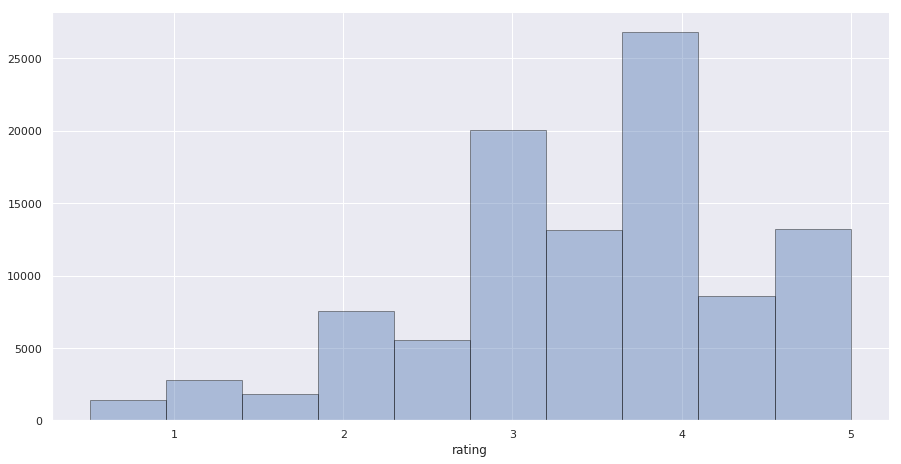

In [27]:
plt.figure(figsize=(15,7.5))
sns.set(style="darkgrid")
sns.distplot(df['rating'].dropna(), bins=10, kde=False, hist_kws={'edgecolor':'black'})
sns.despine()

In [28]:
avg_ratings= df.groupby('movieId', as_index=False).mean()
del avg_ratings['userId']
avg_ratings.head()

,movieId,rating
0,1,3.920930
1,2,3.431818
2,3,3.259615
3,4,2.357143
4,5,3.071429


In [29]:
mov_avg_rtg = movies.merge(avg_ratings, on='movieId', how='inner')
mov_avg_rtg.head()

,movieId,title,genres,year,only_title,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,Toy Story,3.920930
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995,Jumanji,3.431818
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,Grumpier Old Men,3.259615
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995,Waiting to Exhale,2.357143
4,5,Father of the Bride Part II (1995),Comedy,1995,Father of the Bride Part II,3.071429


In [30]:
dftmp = rating[['userId', 'movieId']].groupby('movieId').count()
dftmp.columns=['num_ratings']

movieId
1                                        Toy Story (1995)
47                            Seven (a.k.a. Se7en) (1995)
50                             Usual Suspects, The (1995)
110                                     Braveheart (1995)
150                                      Apollo 13 (1995)
260             Star Wars: Episode IV - A New Hope (1977)
296                                   Pulp Fiction (1994)
318                      Shawshank Redemption, The (1994)
356                                   Forrest Gump (1994)
480                                  Jurassic Park (1993)
527                               Schindler's List (1993)
589                     Terminator 2: Judgment Day (1991)
593                      Silence of the Lambs, The (1991)
780                  Independence Day (a.k.a. ID4) (1996)
1196    Star Wars: Episode V - The Empire Strikes Back...
2571                                   Matrix, The (1999)
2858                               American Beauty (1999)
2959  

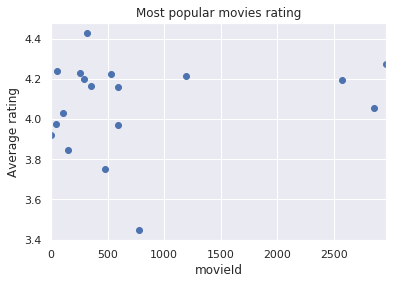

In [31]:
n=200 
print(movies.set_index('movieId').loc[dftmp.index[dftmp.num_ratings>n]]['title'])
rating.set_index('movieId').loc[dftmp.index[dftmp.num_ratings>n]].groupby('movieId').mean().rating.plot(style='o')
plt.ylabel('Average rating')
plt.title('Most popular movies rating')
plt.show()

In [32]:
tmp = rating.set_index('movieId').loc[dftmp.index[dftmp.num_ratings>n]].groupby('movieId').mean()
best = movies.set_index('movieId').loc[tmp.rating.idxmax].title
print ('Best most popular movie ever is...%s' %best)


Best most popular movie ever is...Shawshank Redemption, The (1994)


### Reglas de asociación basada en películas

- Item: Peliculas vistas por un usuario
- I: todas las peliculas vistas por los usuarios
- Transacción: peliculas vistas por cada usuario

In [33]:
shrt_data_userId_ord=df.sort_values( by='userId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
shrt_data_userId_ord.head()

,userId,movieId,rating,title,genres,year,only_title
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,Toy Story
12117,1,2389,2.0,Psycho (1998),Crime|Horror|Thriller,1998,Psycho
12126,1,2395,5.0,Rushmore (1998),Comedy|Drama,1998,Rushmore
12182,1,2406,4.0,Romancing the Stone (1984),Action|Adventure|Comedy|Romance,1984,Romancing the Stone
776,1,70,3.0,From Dusk Till Dawn (1996),Action|Comedy|Horror|Thriller,1996,From Dusk Till Dawn


In [34]:
srtdr=shrt_data_userId_ord.values[:,[0,6]]
print(srtdr)

[[1 'Toy Story ']
 [1 'Psycho ']
 [1 'Rushmore ']
 ...
 [610 'Coraline ']
 [610 'Serious Man, A ']
 [610 '31 ']]


In [35]:
transactions=[]
for title, userId  in groupby(srtdr, lambda x: x[0]):
    transactions.append([item[1] for item in  userId])
#print(transactions)


In [36]:
#min_support y min_confiden entre 0 y 1  
itemsets, rules = apriori(transactions, min_support=0.3,  min_confidence=0.3)
itemsets, rules

({1: {('Aladdin ',): 183,
   ('American Beauty ',): 204,
   ('Apollo 13 ',): 201,
   ('Batman ',): 189,
   ('Braveheart ',): 237,
   ('Fight Club ',): 218,
   ('Forrest Gump ',): 329,
   ('Fugitive, The ',): 190,
   ('Godfather, The ',): 192,
   ('Independence Day (a.k.a. ID4) ',): 202,
   ('Jurassic Park ',): 238,
   ('Lord of the Rings: The Fellowship of the Ring, The ',): 198,
   ('Lord of the Rings: The Return of the King, The ',): 185,
   ('Lord of the Rings: The Two Towers, The ',): 188,
   ('Matrix, The ',): 278,
   ('Pulp Fiction ',): 307,
   ('Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) ',): 200,
   ('Saving Private Ryan ',): 188,
   ("Schindler's List ",): 220,
   ('Seven (a.k.a. Se7en) ',): 203,
   ('Shawshank Redemption, The ',): 317,
   ('Silence of the Lambs, The ',): 279,
   ('Star Wars: Episode IV - A New Hope ',): 251,
   ('Star Wars: Episode V - The Empire Strikes Back ',): 211,
   ('Star Wars: Episode VI - Return of the Jedi ',): 196,
   (

In [37]:
rules=sorted(rules, key=lambda rule: rule.confidence)
for rule in rules:
  print(rule) # Prints the rule and its confidence, support, lift, ...

{Forrest Gump } -> {Braveheart } (conf: 0.556, supp: 0.300, lift: 1.432, conv: 1.378)
{Forrest Gump } -> {Matrix, The } (conf: 0.590, supp: 0.318, lift: 1.294, conv: 1.326)
{Forrest Gump } -> {Jurassic Park } (conf: 0.602, supp: 0.325, lift: 1.542, conv: 1.532)
{Forrest Gump } -> {Silence of the Lambs, The } (conf: 0.605, supp: 0.326, lift: 1.322, conv: 1.373)
{Shawshank Redemption, The } -> {Silence of the Lambs, The } (conf: 0.628, supp: 0.326, lift: 1.373, conv: 1.458)
{Matrix, The } -> {Star Wars: Episode IV - A New Hope } (conf: 0.658, supp: 0.300, lift: 1.600, conv: 1.722)
{Pulp Fiction } -> {Silence of the Lambs, The } (conf: 0.674, supp: 0.339, lift: 1.474, conv: 1.666)
{Matrix, The } -> {Forrest Gump } (conf: 0.698, supp: 0.318, lift: 1.294, conv: 1.525)
{Forrest Gump } -> {Pulp Fiction } (conf: 0.699, supp: 0.377, lift: 1.389, conv: 1.651)
{Shawshank Redemption, The } -> {Pulp Fiction } (conf: 0.700, supp: 0.364, lift: 1.392, conv: 1.657)
{Forrest Gump } -> {Shawshank Redempt

### Reglas de asociación basada en el rating

- Item: Peliculas vistas por un usuario con un rating mayor o igual que 4
- I: todas las peliculas vistas todos por todos los usuarios con rating mayor o igual que 4
- Transacción: peliculas vistas por cada usuario con un rating mayor o igual que 4

In [38]:
shrt_data_userId_ord=df.sort_values( by='rating', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
shrt_data_userId_ord.head()

,userId,movieId,rating,title,genres,year,only_title
22891,116,2683,0.5,Austin Powers: The Spy Who Shagged Me (1999),Action|Adventure|Comedy,1999,Austin Powers: The Spy Who Shagged Me
100117,599,6557,0.5,Born to Be Wild (1995),Adventure|Children|Comedy|Drama,1995,Born to Be Wild
86341,89,946,0.5,To Be or Not to Be (1942),Comedy|Drama|War,1942,To Be or Not to Be
91521,298,1107,0.5,Loser (1991),Comedy,1991,Loser
18311,3,1124,0.5,On Golden Pond (1981),Drama,1981,On Golden Pond


In [39]:
shrt_data_userId_ord = shrt_data_userId_ord[shrt_data_userId_ord['rating']>=4]
shrt_data_userId_ord

,userId,movieId,rating,title,genres,year,only_title
91301,156,2349,4.0,Mona Lisa (1986),Comedy|Thriller,1986,Mona Lisa
89784,339,52319,4.0,Inglorious Bastards (Quel maledetto treno blin...,Action|Adventure|Drama|War,1978,Inglorious Bastards (Quel maledetto treno blin...
91435,156,3492,4.0,"Son of the Sheik, The (1926)",Adventure|Comedy|Romance,1926,"Son of the Sheik, The"
64707,169,3159,4.0,Fantasia 2000 (1999),Animation|Children|Musical|IMAX,1999,Fantasia 2000
90532,313,1344,4.0,Cape Fear (1962),Crime|Drama|Thriller,1962,Cape Fear
...,...,...,...,...,...,...,...
71101,483,1262,5.0,"Great Escape, The (1963)",Action|Adventure|Drama|War,1963,"Great Escape, The"
13469,356,2692,5.0,Run Lola Run (Lola rennt) (1998),Action|Crime,1998,Run Lola Run (Lola rennt)
31617,507,377,5.0,Speed (1994),Action|Romance|Thriller,1994,Speed
31580,372,377,5.0,Speed (1994),Action|Romance|Thriller,1994,Speed


In [40]:
shrt_data_userId_ord_1=shrt_data_userId_ord.head(5)
shrt_data_userId_ord_1

,userId,movieId,rating,title,genres,year,only_title
91301,156,2349,4.0,Mona Lisa (1986),Comedy|Thriller,1986,Mona Lisa
89784,339,52319,4.0,Inglorious Bastards (Quel maledetto treno blin...,Action|Adventure|Drama|War,1978,Inglorious Bastards (Quel maledetto treno blin...
91435,156,3492,4.0,"Son of the Sheik, The (1926)",Adventure|Comedy|Romance,1926,"Son of the Sheik, The"
64707,169,3159,4.0,Fantasia 2000 (1999),Animation|Children|Musical|IMAX,1999,Fantasia 2000
90532,313,1344,4.0,Cape Fear (1962),Crime|Drama|Thriller,1962,Cape Fear


In [41]:
shrt_data_userId_ord_2=shrt_data_userId_ord.tail(5)
shrt_data_userId_ord_2

,userId,movieId,rating,title,genres,year,only_title
71101,483,1262,5.0,"Great Escape, The (1963)",Action|Adventure|Drama|War,1963,"Great Escape, The"
13469,356,2692,5.0,Run Lola Run (Lola rennt) (1998),Action|Crime,1998,Run Lola Run (Lola rennt)
31617,507,377,5.0,Speed (1994),Action|Romance|Thriller,1994,Speed
31580,372,377,5.0,Speed (1994),Action|Romance|Thriller,1994,Speed
9802,380,1580,5.0,Men in Black (a.k.a. MIB) (1997),Action|Comedy|Sci-Fi,1997,Men in Black (a.k.a. MIB)


In [42]:
shrt_data_userId_ord =  pd.concat([shrt_data_userId_ord_1, shrt_data_userId_ord_2])
shrt_data_userId_ord

,userId,movieId,rating,title,genres,year,only_title
91301,156,2349,4.0,Mona Lisa (1986),Comedy|Thriller,1986,Mona Lisa
89784,339,52319,4.0,Inglorious Bastards (Quel maledetto treno blin...,Action|Adventure|Drama|War,1978,Inglorious Bastards (Quel maledetto treno blin...
91435,156,3492,4.0,"Son of the Sheik, The (1926)",Adventure|Comedy|Romance,1926,"Son of the Sheik, The"
64707,169,3159,4.0,Fantasia 2000 (1999),Animation|Children|Musical|IMAX,1999,Fantasia 2000
90532,313,1344,4.0,Cape Fear (1962),Crime|Drama|Thriller,1962,Cape Fear
71101,483,1262,5.0,"Great Escape, The (1963)",Action|Adventure|Drama|War,1963,"Great Escape, The"
13469,356,2692,5.0,Run Lola Run (Lola rennt) (1998),Action|Crime,1998,Run Lola Run (Lola rennt)
31617,507,377,5.0,Speed (1994),Action|Romance|Thriller,1994,Speed
31580,372,377,5.0,Speed (1994),Action|Romance|Thriller,1994,Speed
9802,380,1580,5.0,Men in Black (a.k.a. MIB) (1997),Action|Comedy|Sci-Fi,1997,Men in Black (a.k.a. MIB)


In [43]:
srtdr=shrt_data_userId_ord.values[:,[2,6]]
print(srtdr)

[[4.0 'Mona Lisa ']
 [4.0 'Inglorious Bastards (Quel maledetto treno blindato) ']
 [4.0 'Son of the Sheik, The ']
 [4.0 'Fantasia 2000 ']
 [4.0 'Cape Fear ']
 [5.0 'Great Escape, The ']
 [5.0 'Run Lola Run (Lola rennt) ']
 [5.0 'Speed ']
 [5.0 'Speed ']
 [5.0 'Men in Black (a.k.a. MIB) ']]


In [44]:
transactions=[]
for title, year  in groupby(srtdr, lambda x: x[0]):
    transactions.append([item[1] for item in  year])
print(transactions)


[['Mona Lisa ', 'Inglorious Bastards (Quel maledetto treno blindato) ', 'Son of the Sheik, The ', 'Fantasia 2000 ', 'Cape Fear '], ['Great Escape, The ', 'Run Lola Run (Lola rennt) ', 'Speed ', 'Speed ', 'Men in Black (a.k.a. MIB) ']]


In [45]:
#min_support y min_confiden entre 0 y 1  
itemsets, rules = apriori(transactions, min_support=0.5,  min_confidence=0.8)
itemsets

{1: {('Cape Fear ',): 1,
  ('Fantasia 2000 ',): 1,
  ('Great Escape, The ',): 1,
  ('Inglorious Bastards (Quel maledetto treno blindato) ',): 1,
  ('Men in Black (a.k.a. MIB) ',): 1,
  ('Mona Lisa ',): 1,
  ('Run Lola Run (Lola rennt) ',): 1,
  ('Son of the Sheik, The ',): 1,
  ('Speed ',): 1},
 2: {('Cape Fear ', 'Fantasia 2000 '): 1,
  ('Cape Fear ', 'Inglorious Bastards (Quel maledetto treno blindato) '): 1,
  ('Cape Fear ', 'Mona Lisa '): 1,
  ('Cape Fear ', 'Son of the Sheik, The '): 1,
  ('Fantasia 2000 ',
   'Inglorious Bastards (Quel maledetto treno blindato) '): 1,
  ('Fantasia 2000 ', 'Mona Lisa '): 1,
  ('Fantasia 2000 ', 'Son of the Sheik, The '): 1,
  ('Great Escape, The ', 'Men in Black (a.k.a. MIB) '): 1,
  ('Great Escape, The ', 'Run Lola Run (Lola rennt) '): 1,
  ('Great Escape, The ', 'Speed '): 1,
  ('Inglorious Bastards (Quel maledetto treno blindato) ', 'Mona Lisa '): 1,
  ('Inglorious Bastards (Quel maledetto treno blindato) ',
   'Son of the Sheik, The '): 1,
  (

In [46]:
rules

[{Fantasia 2000 } -> {Cape Fear },
 {Cape Fear } -> {Fantasia 2000 },
 {Inglorious Bastards (Quel maledetto treno blindato) } -> {Cape Fear },
 {Cape Fear } -> {Inglorious Bastards (Quel maledetto treno blindato) },
 {Mona Lisa } -> {Cape Fear },
 {Cape Fear } -> {Mona Lisa },
 {Son of the Sheik, The } -> {Cape Fear },
 {Cape Fear } -> {Son of the Sheik, The },
 {Inglorious Bastards (Quel maledetto treno blindato) } -> {Fantasia 2000 },
 {Fantasia 2000 } -> {Inglorious Bastards (Quel maledetto treno blindato) },
 {Mona Lisa } -> {Fantasia 2000 },
 {Fantasia 2000 } -> {Mona Lisa },
 {Son of the Sheik, The } -> {Fantasia 2000 },
 {Fantasia 2000 } -> {Son of the Sheik, The },
 {Men in Black (a.k.a. MIB) } -> {Great Escape, The },
 {Great Escape, The } -> {Men in Black (a.k.a. MIB) },
 {Run Lola Run (Lola rennt) } -> {Great Escape, The },
 {Great Escape, The } -> {Run Lola Run (Lola rennt) },
 {Speed } -> {Great Escape, The },
 {Great Escape, The } -> {Speed },
 {Mona Lisa } -> {Inglorious

In [47]:
rules=sorted(rules, key=lambda rule: rule.confidence)
for rule in rules:
  print(rule) .

{Fantasia 2000 } -> {Cape Fear } (conf: 1.000, supp: 0.500, lift: 2.000, conv: 500000000.000)
{Cape Fear } -> {Fantasia 2000 } (conf: 1.000, supp: 0.500, lift: 2.000, conv: 500000000.000)
{Inglorious Bastards (Quel maledetto treno blindato) } -> {Cape Fear } (conf: 1.000, supp: 0.500, lift: 2.000, conv: 500000000.000)
{Cape Fear } -> {Inglorious Bastards (Quel maledetto treno blindato) } (conf: 1.000, supp: 0.500, lift: 2.000, conv: 500000000.000)
{Mona Lisa } -> {Cape Fear } (conf: 1.000, supp: 0.500, lift: 2.000, conv: 500000000.000)
{Cape Fear } -> {Mona Lisa } (conf: 1.000, supp: 0.500, lift: 2.000, conv: 500000000.000)
{Son of the Sheik, The } -> {Cape Fear } (conf: 1.000, supp: 0.500, lift: 2.000, conv: 500000000.000)
{Cape Fear } -> {Son of the Sheik, The } (conf: 1.000, supp: 0.500, lift: 2.000, conv: 500000000.000)
{Inglorious Bastards (Quel maledetto treno blindato) } -> {Fantasia 2000 } (conf: 1.000, supp: 0.500, lift: 2.000, conv: 500000000.000)
{Fantasia 2000 } -> {Inglori